In [1]:
cd ~/Desktop/CS109/Data

/Users/Leah/Desktop/CS109/Data


In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import copy
from itertools import product
pd.options.display.max_columns
from matplotlib.ticker import ScalarFormatter

In [3]:
# read in ADNIMERGE.csv where protocol is ADNI2
ADNIMERGE = pd.read_csv('ADNIMERGE.csv')
ADNIMERGE = ADNIMERGE[ADNIMERGE['COLPROT'] == 'ADNI2']
ADNIMERGE = ADNIMERGE.set_index('PTID')

# Read in gene expression data
GENE_EXPRESSION = pd.read_csv('ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile.csv', low_memory=False, index_col=0, header=2)
GENE_EXPRESSION = GENE_EXPRESSION[6:]
GENE_EXPRESSION = GENE_EXPRESSION.rename(columns={GENE_EXPRESSION.columns[0]: 'ProbeSet', GENE_EXPRESSION.columns[1]: 'LocusLink'})
GENE_EXPRESSION = GENE_EXPRESSION.transpose()

# Save gene expression data and info on genes separately
GENE_EXPRESSION_DATA = GENE_EXPRESSION[2:]
GENE_EXPRESSION_GENE_INFO = GENE_EXPRESSION[:2]
GENE_EXPRESSION_GENE_INFO.columns = GENE_EXPRESSION_GENE_INFO.columns.values

# write info on how genes are stored to csv
GENE_EXPRESSION_GENE_INFO.to_csv('GENE_EXPRESSION_GENE_INFO.csv')

# data about patient and collection of gene expression data
GENE_EXPRESSION_head = pd.read_csv('ADNI_Gene_Expression_Profile/ADNI_Gene_Expression_Profile.csv', low_memory=False, nrows=8, header=None)
GENE_EXPRESSION_head.columns = GENE_EXPRESSION_head.iloc[2].values
GENE_EXPRESSION_head = GENE_EXPRESSION_head.transpose()
GENE_EXPRESSION_head.columns = GENE_EXPRESSION_head.iloc[0]
GENE_EXPRESSION_head = GENE_EXPRESSION_head[3:]
GENE_EXPRESSION_head = GENE_EXPRESSION_head.drop(['SubjectID'], axis=1)

# join gene expression data to gene expression data collection information
GENE_EXPRESSION_MERGE = GENE_EXPRESSION_head
GENE_EXPRESSION_MERGE = GENE_EXPRESSION_MERGE.join(GENE_EXPRESSION_DATA)
GENE_EXPRESSION_MERGE = GENE_EXPRESSION_MERGE[GENE_EXPRESSION_MERGE['Phase'] == 'ADNI2']

# join ADNIMERGE data to gene expression data
GENE_EXPRESSION_MERGE = GENE_EXPRESSION_MERGE.join(ADNIMERGE)

# create new index so don't index using SubjectID
GENE_EXPRESSION_MERGE.reset_index(inplace=True)
GENE_EXPRESSION_MERGE = GENE_EXPRESSION_MERGE.rename(columns={'index': 'SubjectID'})



In [4]:
# just collect info about visits
GENE_EXPRESSION_VISITS = GENE_EXPRESSION_MERGE[['Visit', 'YearofCollection', 'VISCODE', 'EXAMDATE', 'EXAMDATE_bl']]
# convert datatypes to datetime
GENE_EXPRESSION_VISITS['EXAMDATE'] =pd.to_datetime(GENE_EXPRESSION_VISITS.EXAMDATE)

# have only one row per patient. cog tests of visit where expression data taken
# get longitudinal data on diagnosis (first, final, and when each)

unique_IDs = GENE_EXPRESSION_MERGE.SubjectID.unique()
first_visit_list = []
first_date_list = []
final_visit_list = []
final_date_list = []

GENE_EXPRESSION_UNIQUE_VISITS = pd.DataFrame()
temp_list = []
print('SubjectID\t\tVisit-type')
for ID in unique_IDs:
    ALL_VISITS = GENE_EXPRESSION_MERGE.loc[GENE_EXPRESSION_MERGE['SubjectID'] == ID]
    ALL_VISITS['EXAMDATE'] = pd.to_datetime(ALL_VISITS.EXAMDATE)
    SORTED = ALL_VISITS.sort_values('EXAMDATE')
    VISITID = ALL_VISITS.Visit.iloc[0]
    if VISITID == 'v03':
        temp_list.append(ALL_VISITS.loc[ALL_VISITS['VISCODE'] == 'bl'])
    elif VISITID == 'v06':
        temp_list.append(SORTED.iloc[[0]])
    elif VISITID == 'v11':
        code = SORTED.iloc[[0]].VISCODE.values[0]
        if code == 'bl':
            new_code = 'm12'
        else:
            new_code = 'm' + str(int(code[1:]) + 12)
        if ALL_VISITS.loc[ALL_VISITS['VISCODE'] == new_code].empty == True:
            print(ALL_VISITS[['SubjectID', 'Visit', 'YearofCollection', 'VISCODE', 'EXAMDATE', 'EXAMDATE_bl']])
        temp_list.append(ALL_VISITS.loc[ALL_VISITS['VISCODE'] == new_code])
    elif VISITID == 'v04':
        temp_list.append(ALL_VISITS.loc[ALL_VISITS['VISCODE'] == 'm03'])
    elif VISITID == 'v05':
        temp_list.append(ALL_VISITS.loc[ALL_VISITS['VISCODE'] == 'm06'])
    elif VISITID == 'v02':
        # only one case\
        temp_list.append(ALL_VISITS)
    else:
        print('{0}\t\t{1}'.format(ID, VISITID))
    
    index = 0
    first_visit = SORTED.iloc[[index]]
    first_DX = first_visit['DX'].values[0]
    first_date = first_visit['EXAMDATE'].values[0]
    #print('initial first DX is: ', first_DX)
    while first_visit.DX.isnull().values.any() == True:
        if index > len(SORTED.index) - 1:
            break
        index += 1
        first_visit = SORTED.iloc[[index]]
        first_DX = first_visit['DX'].values[0]
        first_date = first_visit['EXAMDATE'].values[0]
        #print('For subject {0}, index is {1} and DX is {2}'.format(ID, index, first_DX))
    first_visit_list.append(first_DX)
    first_date_list.append(first_date)
    
    index = len(SORTED.index) - 1
    final_visit = SORTED.iloc[[index]]
    final_DX = final_visit['DX'].values[0]
    final_date = final_visit['EXAMDATE'].values[0]
    #print('initial final DX is: ', final_DX)
    while final_visit.DX.isnull().values.any() == True:
        if index < 0:
            break
        index -= 1
        final_visit = SORTED.iloc[[index]]
        final_DX = final_visit['DX'].values[0]
        final_date = final_visit['EXAMDATE'].values[0]
        #print('For subject {0}, index is {1} and DX is {2}'.format(ID, index, final_DX))
    final_visit_list.append(final_DX)
    final_date_list.append(final_date)
    
GENE_EXPRESSION_UNIQUE_VISITS = pd.concat(temp_list)
GENE_EXPRESSION_UNIQUE_VISITS['First_DX'] = first_visit_list
GENE_EXPRESSION_UNIQUE_VISITS['First_date'] = first_date_list
GENE_EXPRESSION_UNIQUE_VISITS['Final_DX'] = final_visit_list
GENE_EXPRESSION_UNIQUE_VISITS['Final_date'] = final_date_list
GENE_EXPRESSION_UNIQUE_VISITS['First_Delta_Time'] = (GENE_EXPRESSION_UNIQUE_VISITS.EXAMDATE-GENE_EXPRESSION_UNIQUE_VISITS.First_date).astype('timedelta64[D]')
GENE_EXPRESSION_UNIQUE_VISITS['Final_Delta_Time'] = (GENE_EXPRESSION_UNIQUE_VISITS.Final_date-GENE_EXPRESSION_UNIQUE_VISITS.EXAMDATE).astype('timedelta64[D]')

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


SubjectID		Visit-type


/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [5]:
# convert numbers to floats
TEMP = GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,:8]
TEMP = TEMP.join(GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49394:])
GENE_EXPRESSION_UNIQUE_VISITS = GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,8:49394].astype('float64', copy=True)
GENE_EXPRESSION_UNIQUE_VISITS = GENE_EXPRESSION_UNIQUE_VISITS.join(TEMP)

# convert types of columns as necessary
GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49445] = pd.to_datetime(GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49445])
GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49399] = pd.to_datetime(GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49399])
GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49389:49392] = GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49389:49392].astype('float64', copy=True)
GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49392:49394] = GENE_EXPRESSION_UNIQUE_VISITS.iloc[:,49392:49394].astype('int64', copy=True)

# convert DX and Final_DX values to numbers for logistic classification
cleanup_nums = {'DX':     {'CN': 0, 'MCI': 1, 'Dementia': 2},
                'First_DX': {'CN': 0, 'MCI': 1, 'Dementia': 2},
                'Final_DX': {'CN': 0, 'MCI': 1, 'Dementia': 2}}
GENE_EXPRESSION_UNIQUE_VISITS.replace(cleanup_nums, inplace=True)

In [6]:
GENE_EXPRESSION_UNIQUE_VISITS.to_csv('gene_expression_unique.csv')

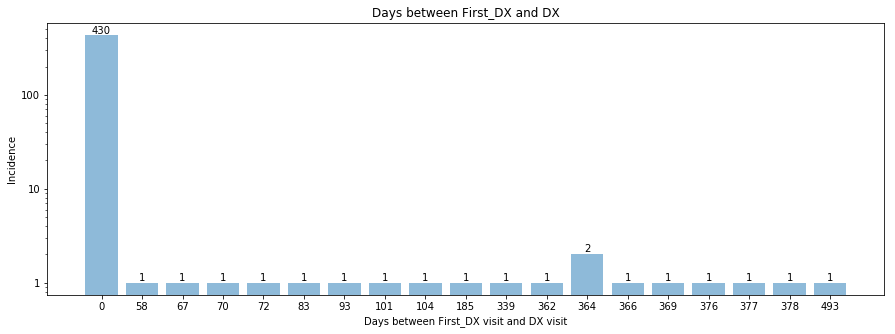

In [7]:
meetings_count = GENE_EXPRESSION_UNIQUE_VISITS.groupby(['First_Delta_Time']).size()
objects = list(meetings_count.index)
y_pos = np.arange(len(objects))
objects = list(map(int, objects))
performance = list(meetings_count.values)


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15,5))
ax.bar(y_pos, performance, align='center', alpha=0.5)
bars = ax.patches
plt.xticks(y_pos, objects)
ax.set_ylabel('Incidence')
ax.set_yscale('log')
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_xlabel('Days between First_DX visit and DX visit')
ax.set_title('Days between First_DX and DX')
for bar, count in zip(bars, performance):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height*1.0005, count, ha = 'center', va = 'bottom', fontsize = 10)
    
